# 图像分类

在此项目中，你将对 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图片进行分类。


### 图片读取和呈现
读取pickle文件，或者单张图像，jpeg等格式。

automobile


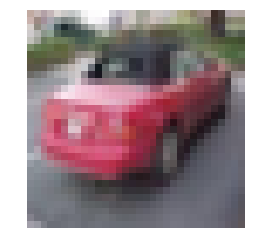

In [30]:
#读取pickle格式
import pickle
import matplotlib.pyplot as plt

batch_id = 2
with open('cifar-10-batches-py/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels = batch['labels']
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x = 100
print(label_names[labels[x]])
plt.axis('off')
plt.imshow(features[x])
plt.show()

## 实现预处理函数

### 标准化

在下面的单元中，实现 `normalize` 函数，传入图片数据 `x`，并返回标准化 Numpy 数组。值应该在 0 到 1 的范围内（含 0 和 1）。返回对象应该和 `x` 的形状一样。


In [9]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return  (x-x.min())/(x.max() - x.min())


In [10]:
features_normal = normalize(features)
#plt.imshow(features_normal[1])

### One-hot 编码

和之前的代码单元一样，你将为预处理实现一个函数。这次，你将实现 `one_hot_encode` 函数。输入，也就是 `x`，是一个标签列表。实现该函数，以返回为 one_hot 编码的 Numpy 数组的标签列表。标签的可能值为 0 到 9。每次调用 `one_hot_encode` 时，对于每个值，one_hot 编码函数应该返回相同的编码。确保将编码映射保存到该函数外面。

提示：不要重复发明轮子。


In [11]:
import pandas as pd

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    import numpy as np
    ohot = np.zeros((len(x),10))
    for i in range(len(x)):
        ohot[i][x[i]] = 1
    return ohot


In [31]:
labels_ohot = one_hot_encode(labels)
print(labels[1])
labels_ohot[1]

6


array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

## 构建cnn网络





### 卷积

卷积层实现对图片对特征表示。说简单点，就是用滤波器去提取图片中的特征，比如线条、颜色等；再通过不同层之间多滤波器对特征进行组合。
<img style="width: 25cm;" src="lenet-5.png"/>


涉及的主要概念有，滤波器（filter，也会叫kernel）：patch, stride，depth，padding；  
参数共享和激活函数。

**滤波器**  
用来实现特征提取
<img style="width: 10cm;" src="conv.jpeg"/>

**padding**
<img style="width: 15cm" src = "padding.png">

TensorFlow 使用如下等式计算 SAME 、VALID PADDING

SAME Padding   
输出的高和宽，计算如下：  
out_height = ceil(float(in_height) / float(strides1))  
out_width = ceil(float(in_width) / float(strides[2]))

VALID Padding  
输出的高和宽，计算如下：  
out_height = ceil(float(in_height - filter_height + 1) / float(strides1))  
out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))


**参数共享**  
每个patch都共用一个权重矩阵。

**激活函数**  
常用到Relu，Leaky Relu。
<img style="width: 10cm;" src="relu.png"/>


### pooling

池化层总的来说是用来**减少输出大小**和**避免过拟合**。
一个直观的效果是，可以克服位置偏移带来的干扰。  
<img style="width: 10cm;" src="max_pool.jpeg"/>


近期，池化层并不是很受青睐。部分原因是：

现在的数据集又大又复杂，我们更关心欠拟合问题。  
Dropout 是一个更好的正则化方法。  
池化导致信息损失。想想最大池化的例子，n 个数字中我们只保留最大的，把余下的 n-1 完全舍弃了。


### dropout
<img style = "width: 15cm;" src = "dropout.jpeg">

**仿人类**  
**类似于bagging思想**


In [13]:
def cnn_network(image_input,keep_prob):
    # 32*32*3 conv to 16*16*64
    layer = tf.layers.conv2d(image_input, 64, 5, 2, padding = 'same')
    layer = tf.nn.relu(layer)
    
    # 16*16*64 max_pool  8*8*64
#     layer = tf.nn.max_pool(layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
    
    # 8*8*64 conv to 4*4*128
    layer = tf.layers.conv2d(layer, 128, 5, 2, padding = 'same')
    layer = tf.nn.relu(layer)
    
    # 4*4*128 conv to 2*2*128
#     layer = tf.nn.max_pool(layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
    
    
    # 2*2*128 conv to 1*1*256
#     layer = tf.layers.conv2d(layer, 256, 5, 2, padding = 'same')
#     layer = tf.nn.relu(layer)
    
    # flatten layer
    batch,h,w,c = layer.shape.as_list()
    layer = tf.reshape(layer, [-1, h * w * c])
    
    # fully connected layer
    output = tf.layers.dense(layer,10)
    output = tf.nn.dropout(output,keep_prob)
    
    return output

### 构建tensorflow
tensorflow需要先构建tensor board，随后在Session里，通过feed_dict把数据传进去，再做运算。

In [14]:
##############################
## Build the Neural Network ##
##############################

import tensorflow as tf
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
image = tf.placeholder(tf.float32, (None, 32, 32, 3), name = 'image')
label = tf.placeholder(tf.int32, (None, 10), name = 'label')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

# Model
logits = cnn_network(image, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



## 训练神经网络

### batch
batch大小对结果影响很大，是主要调参对象。batch小，error震荡厉害，稍微大，更平滑。


In [15]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


### 单次优化


In [16]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,feed_dict={
                image: feature_batch,
                label: label_batch,
                keep_prob: keep_probability})

### 显示训练过程

In [17]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = sess.run(cost, feed_dict={
                image: feature_batch,
                label: label_batch,
                keep_prob: 1.})
#     valid_acc = sess.run(accuracy, feed_dict={
#                 image: valid_features,
#                 label: valid_labels,
#                 keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,#valid_acc
                0))

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `keep_probability` 表示使用丢弃时保留节点的概率

In [18]:
# TODO: Tune Parameters
epochs = 10
batch_size = 128
keep_probability = 0.8

### 在单个 CIFAR-10 部分上训练

我们先用单个部分，而不是用所有的 CIFAR-10 批次训练神经网络。这样可以节省时间，并对模型进行迭代，以提高准确率。最终验证准确率达到 50% 或以上之后，在下一部分对所有数据运行模型。


In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
save_model_path = './image_classification'
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 2
        for batch_features, batch_labels in batch_features_labels(features_normal, labels_ohot, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
        
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7105 Validation Accuracy: 0.000000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3441 Validation Accuracy: 0.000000
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.0880 Validation Accuracy: 0.000000
Epoch  4, CIFAR-10 Batch 2:  Loss:     0.9795 Validation Accuracy: 0.000000
Epoch  5, CIFAR-10 Batch 2:  Loss:     0.6985 Validation Accuracy: 0.000000
Epoch  6, CIFAR-10 Batch 2:  Loss:     0.5059 Validation Accuracy: 0.000000
Epoch  7, CIFAR-10 Batch 2:  Loss:     0.4633 Validation Accuracy: 0.000000
Epoch  8, CIFAR-10 Batch 2:  Loss:     0.3535 Validation Accuracy: 0.000000
Epoch  9, CIFAR-10 Batch 2:  Loss:     0.2605 Validation Accuracy: 0.000000
Epoch 10, CIFAR-10 Batch 2:  Loss:     0.2552 Validation Accuracy: 0.000000


### 测试模型
加载模型节点

(214, 299, 3)


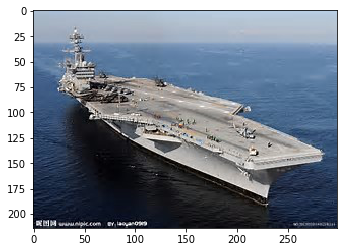

In [32]:
#读取jpeg格式
import matplotlib.image as img
import matplotlib.pyplot as plt

# dog = img.imread('dog_online.jpeg')
# cat = img.imread('cat.jpeg')

# ship1 = img.imread('ship_online.jpeg')
# ship2 = img.imread('ship.jpg')
# ship3 = img.imread('ship_online.png')
# simple_shipe = img.imread('simple_ship.jpeg')
# simple_shipe2 = img.imread('simple_ship.png')
# douhao = img.imread('逗号.jpeg')

online_image = img.imread('ship_online.jpeg')
print(online_image.shape)
plt.imshow(online_image)
plt.show()

### 图片缩放和裁剪
按比例缩放，再裁剪

对原图片按比例缩放再裁减成指定大小，一般会裁多个，中心裁，边缘裁，或者随机裁。将不同对裁剪图片分别用模型跑，最后结果再平均。


**举例**
imageNet上的输入图片的处理就是这么适应输入的，常用的输入大小227x227,358x368等等

以227x227为目标
短边缩放到227，保持宽高比不变。然后用227x227的窗口截图。

也可以先缩放到更大到尺寸，比如256x256，再裁剪


ps：先标准化之后，再缩放裁剪，效果更好。

In [33]:
online_image = normalize(online_image[:,:,:3])
# plt.imshow(online_image)
# plt.show()

/Users/LGB/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


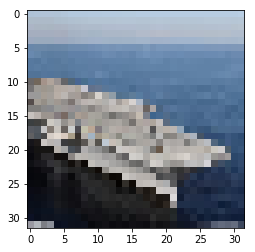

In [34]:
from skimage import transform
h,w,c = online_image.shape
if h < w :
    online_image=transform.resize(online_image, (32,round(w/h*32)))
    h,w,c = online_image.shape
    online_image = online_image[:,(w-h):,:]
else:
    online_image=transform.resize(online_image, (round(h/w*32),32))
    h,w,c = online_image.shape
    online_image = online_image[:,(w-h):,:]

plt.imshow(online_image)
plt.show()

In [35]:
online_image = normalize(online_image[:,:,:3])
#plt.imshow(online_image)
#plt.show()

### 新数据跑模型

In [36]:
import numpy as np
test_feature = online_image.reshape(1,32,32,3)
test_label = np.zeros_like(labels_ohot[1])
test_label = test_label.reshape(1,10)
test_feature.shape

(1, 32, 32, 3)

In [37]:

loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_image = loaded_graph.get_tensor_by_name('image:0')
    loaded_label = loaded_graph.get_tensor_by_name('label:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
    test_batch_acc_total = sess.run(
                loaded_acc,
                feed_dict={loaded_image: test_feature, loaded_label: test_label, loaded_keep_prob: 1.0})

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total))

    # Print Random Samples
    random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), 3),
            feed_dict={loaded_image: test_feature, loaded_label: test_label, loaded_keep_prob: 1.0})


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.0



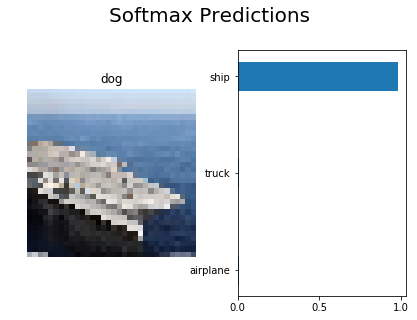

In [38]:
fig, axies = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

n_predictions = 3
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions

pred_indices = random_test_predictions.indices
pred_names = [label_names[pred_i] for pred_i in random_test_predictions.indices[0]]
correct_name = 'dog'

axies[0].imshow(online_image)
axies[0].set_title(correct_name)
axies[0].set_axis_off()

axies[1].barh(ind + margin, random_test_predictions.values[0][::-1], width)
axies[1].set_yticks(ind + margin)
axies[1].set_yticklabels(pred_names[::-1])
axies[1].set_xticks([0, 0.5, 1.0])
plt.show()



## GAN
**gan_diagram**  
<img src = 'gan_diagram.png' style= 'width:15cm'>  
**gan_network**  
<img src = 'gan_network.png' style= 'width:15cm'>


In [28]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                  name = 'input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim), name = 'input_z')
    learnging_rate = tf.placeholder(tf.float32, name = 'learnging_rate')

    return input_real, input_z, learnging_rate

### batch_normalization


In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        
        alpha = 0.2
        
        # 32*32*3 conv to 16x16x64
        h1 = tf.layers.conv2d(images, 64, 5, 2, padding = 'same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.nn.dropout(h1, 0.8)
        
        #16x16x64 conv to 8x8x128
        h2 = tf.layers.conv2d(h1, 128, 5, 2, padding = 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training = True)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, 0.8)
        
        #8x8x128 conv to 4x4x256
        h3 = tf.layers.conv2d(h2, 256, 5, 2, padding = 'same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training = True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, 0.8)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return logits, out

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        alpha = 0.2
        
        #fully connected layer to 
        h1 = tf.layers.dense(z, 4*4*256)
        h1 = tf.reshape(h1, (-1, 4, 4, 256))
        h1 = tf.layers.batch_normalization(h1, training = is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        #4*4*256 trans_conv to 8x8x128
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, 2, padding = 'same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, 0.8)
        
        #8x8x128 trans_conv to 16x16x64
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, 2, padding = 'same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training = is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, 0.8)     

        #16x16x64 trans_conv to 32x32xout_channel_dim
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, padding = 'same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        
    return out

### 辨别器的损失函数平滑


In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_g = generator(input_z, out_channel_dim, is_train = True)
    d_real_logits, d_real_out = discriminator(input_real, reuse = False)
    d_fake_logits, d_fake_out = discriminator(input_g, reuse = True)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, 
                                                                         labels = tf.ones_like(d_real_out) * 0.9))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits,
                                                                        labels = tf.zeros_like(d_fake_out)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits,
                                                                   labels = tf.ones_like(d_fake_out)))
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_var = [var for var in t_vars if var.name.startswith('discriminator')]
    g_var = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_var)
    
    
    return d_train_opt, g_train_opt

### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。


In [59]:
import math
from PIL import Image

def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess_2, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess_2.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

image rescale to (-1,1)

In [61]:
def train(image_input,epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    step = 0
    show_every = 100
    print_every = 10
    n_images = 25
    
    with tf.Session() as sess_2:
        sess_2.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(image_input,batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess_2.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess_2.run(g_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if step%print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}...".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if step%show_every == 0:
                    show_generator_output(sess_2, n_images, input_z, image_channels, data_image_mode)

In [62]:
def get_batches(features, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, 10000, batch_size):
        end = min(start + batch_size, 10000)
        yield features[start:end]

In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

dataset = features_normal[:batch_size,:,:,:]
#dataset = test_feature
with tf.Graph().as_default():
    train(dataset,epochs, batch_size, z_dim, learning_rate, beta1, get_batches,
          dataset.shape, "RGB")

Epoch 1/1... Discriminator Loss: nan... Generator Loss: nan...
Epoch 1/1... Discriminator Loss: nan... Generator Loss: nan...
Epoch 1/1... Discriminator Loss: nan... Generator Loss: nan...


KeyboardInterrupt: 

In [65]:
dataset.shape

(63, 32, 32, 3)